In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [80]:
class Bandit:
    def __init__(self, a, b):
        # Here, the bandits rewards are assumed to have a beta distribution with shape parameters a and b
        self.a = a
        self.b = b
        self.mean_reward = 0
        self.N_j = 0    # number of times bandit j is pulled
    
    # Pulling a bandits arm corresponds in this case to getting a sample from their distribution (which would be
    #    unknown in real life)
    def pull(self):
        # Increase the number of times the bandit is pulled
        self.N_j += 1
        # Draw a sample from the distribution
        reward = np.random.beta(self.a, self.b)
        # update mean reward
        self.mean_reward = (1 - 1 / self.N_j) * self.mean_reward + (1 / self.N_j) * reward
        return reward
def initialize_bandits(bandits, value):
    for b in bandits:
        b.mean_reward = value
        b.N_j = 0

In [81]:
# Bandits that will be used
b1 = Bandit(20, 3)
b2 = Bandit(5, 30)
b3 = Bandit(1, 10)
bandits = [b1, b2, b3]

In [82]:
def epsilon_greedy(num_iter, bandits):
    num_bandits = len(bandits)
    data = np.zeros(num_iter)    # the reward obtained after each iteration
    initialize_bandits(bandits, 0)
    for t in range(num_iter):
        N = t + 1
        epsilon = 1 / N    # instead of using a constant epsilon, using a timely decreasing epsilon will limit exploration when necessary
        # epsilon greedy algorithm:
        #    with a probability epsilon, select a random bandit (explore)
        if np.random.uniform() < epsilon:
            j = np.random.choice(num_bandits)
        #    with a probability 1 - epsilon, select the bandit with the highest mean reward so far (exploit)
        else:
            j = np.argmax(b.mean_reward for b in bandits)
        # Pull selected bandit and get the reward
        current_reward = bandits[j].pull()
        # Save reward obtained
        data[t] = current_reward
    # Get the cumulative average rewards, since they explain the progress of the algorithm better
    cumul_avg_rewards = np.cumsum(data) / (np.arange(1, num_iter + 1))
    return cumul_avg_rewards

In [83]:
epsilon_greedy_data = epsilon_greedy(100000, bandits)

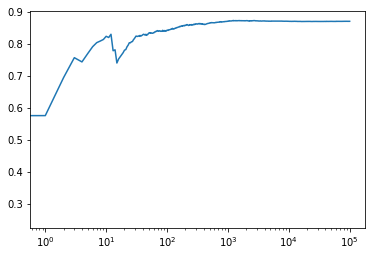

In [84]:
plt.plot(epsilon_greedy_data)
plt.xscale('log')

In [85]:
epsilon_greedy_mean_rewards

array([0.86959091, 0.0070918 , 0.0010711 ])

In [86]:
# The optimistic initial values algorithm is close to a greedy algorithm, except that the initial mean rewards of each bandits are set to high values, thus encouraging
#    exploration of non explored bandits
def optimistic_initial_values(num_iter, bandits, upper_bound):
    num_bandits = len(bandits)
    # set the initial mean rewards to upper_bound (should be a high number)
    initialize_bandits(bandits, upper_bound)
    data = np.zeros(num_iter)
    for t in range(num_iter):
        N = t + 1
        # greedy algorithm: select the bandit with the highest reward
        j = np.argmax(b.mean_reward for b in bandits)
        current_reward = bandits[j].pull()
        # save the reward obtained
        data[t] = current_reward
    # Get the cumulative average rewards, since they explain the progress of the algorithm better
    cumul_avg_rewards = np.cumsum(data) / (np.arange(1, num_iter + 1))
    return cumul_avg_rewards

In [97]:
optimistic_initial_values_data = optimistic_initial_values(100000, bandits, 10)

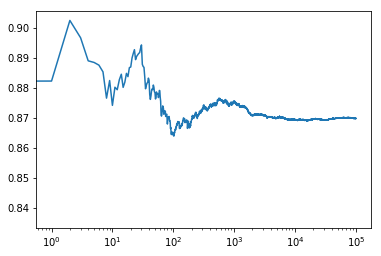

In [98]:
plt.plot(optimistic_initial_values_data)
plt.xscale('log')

In [99]:
# The ucb1 algorithm is the same as the optimistic initial values method, except that instead of the selecting the bandit with the highest expected reward, 
#    we'll select the bandit with the highest upper bound defined as x_ucb_j = x_j + sqrt(2 * ln(N) / N_j), where:
#        - x_j is the expected reward of the j_th bandit
#        - N is the number of iterations
#        - N_j is the number of times the j_th bandit is pulled
# Thus, if N_j is small, then the uper bound is high, causing the j_th bandit to be selected more, and vice versa if N_j is large
# ln(N) grows more slowly than N_j, so eventually all upper bounds will shrink, but by then we'd have collected lots of data, so we can rely only on the mean reward
def ucb1(num_iter, bandits, upper_bound):
    num_bandits = len(bandits)
    # set the initial mean rewards to upper_bound (should be a high number)
    initialize_bandits(bandits, upper_bound)
    data = np.zeros(num_iter)
    for t in range(num_iter):
        N = t + 1
        # greedy algorithm + ucb: select the bandit with the highest upper bound
        j = np.argmax(b.mean_reward + np.sqrt(2 * np.log(N) / (b.N_j + 10 ** -8)) for b in bandits)
        current_reward = bandits[j].pull()
        # save the reward obtained
        data[t] = current_reward
    # Get the cumulative average rewards, since they explain the progress of the algorithm better
    cumul_avg_rewards = np.cumsum(data) / (np.arange(1, num_iter + 1))
    return cumul_avg_rewards

In [102]:
ucb1_data = ucb1(100000, bandits, 10)

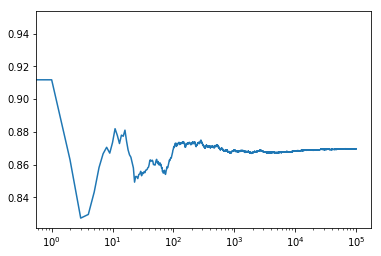

In [103]:
plt.plot(ucb1_data)
plt.xscale('log')

In [114]:
# The thompson sampling sees each expected reward as coming from an unknown beta distribution, and for each bandit, the parameters of its beta distribution will be updated
#    until they are close to the true distrbutions of the expected rewards of each bandit
def thompson_sampling(num_iter, bandits, a_init, b_init):
    num_bandits = len(bandits)
    initialize_bandits(bandits, 0)
    data = np.zeros(num_iter)
    # Initialize the shape parameters of the beta distributions of each bandit
    param = [[a_init, b_init] for b in bandits]
    for t in range(num_iter):
        # Draw a sample from each distribution, then select the bandit with the highest sample
        j = np.argmax(np.random.beta(param[i][0], param[i][1]) for i in range(num_bandits))
        current_reward = bandits[j].pull()
        # update the shape parameters using the rule:
        #    a = a + r                          (r is the reward)
        #    b = b + 1 - r
        param[j][0] += current_reward
        param[j][1] += 1 - current_reward
        # save current reward
        data[t] = current_reward
    # Get the cumulative average rewards, since they explain the progress of the algorithm better
    cumul_avg_rewards = np.cumsum(data) / np.arange(1, num_iter + 1)
    return cumul_avg_rewards

In [115]:
thompson_sampling_data = thompson_sampling(100000, bandits, 2, 2)

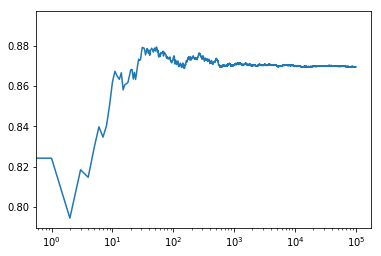

In [116]:
plt.plot(thompson_sampling_data)
plt.xscale('log')

In [126]:
def compare_methods(num_iter, bandits):
    epsilon_greedy_data = epsilon_greedy(num_iter, bandits)
    optimistic_initial_values_data = optimistic_initial_values(num_iter, bandits, 10)
    ucb1_data = ucb1(num_iter, bandits, 10)
    thompson_sampling_data = thompson_sampling(num_iter, bandits, 2, 2)
    plt.figure(figsize = (30, 30))
    plt.plot(epsilon_greedy_data, label = 'epsilon greedy')
    plt.plot(optimistic_initial_values_data, label = 'opt init values')
    plt.plot(ucb1_data, label = 'ucb1')
    plt.plot(thompson_sampling_data, label = 'thompson sampling')
    plt.xscale('log')
    plt.legend()

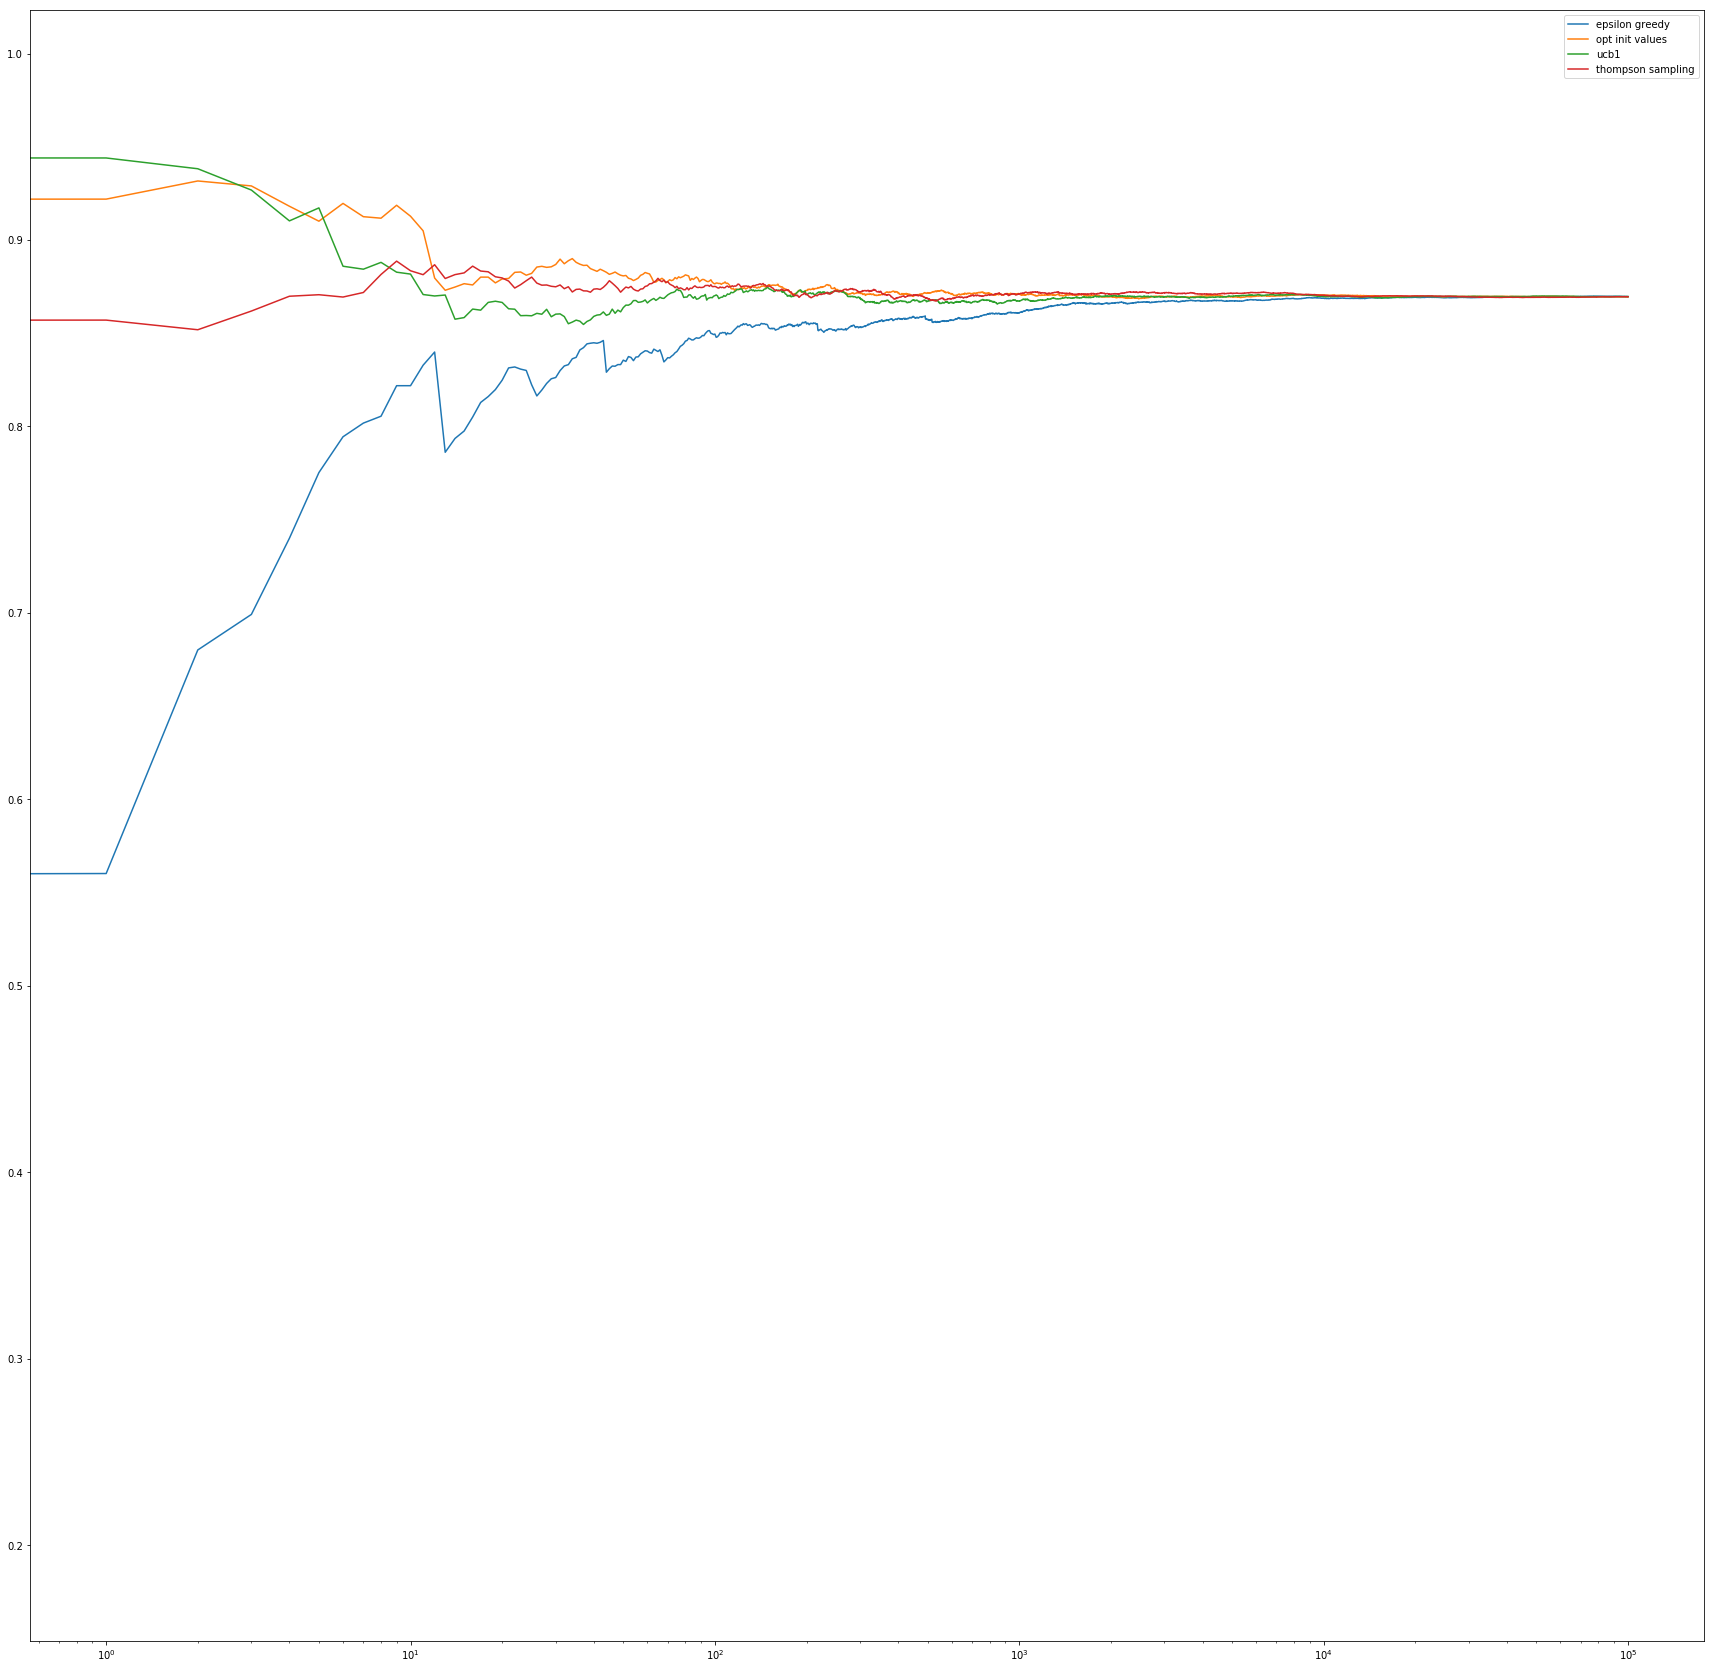

In [127]:
compare_methods(100000, bandits)